# Table of Contents
 <p><div class="lev1"><a href="#Task-1.-Compiling-Ebola-Data"><span class="toc-item-num">Task 1.&nbsp;&nbsp;</span>Compiling Ebola Data</a></div>
 <div class="lev1"><a href="#Task-2.-RNA-Sequences"><span class="toc-item-num">Task 2.&nbsp;&nbsp;</span>RNA Sequences</a></div>
 <div class="lev1"><a href="#Task-3.-Class-War-in-Titanic"><span class="toc-item-num">Task 3.&nbsp;&nbsp;</span>Class War in Titanic</a></div></p>

In [1]:
DATA_FOLDER = 'Data' # Use the data folder provided in Tutorial 02 - Intro to Pandas.
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from dateutil.parser import parse
from os import listdir
from os.path import isfile, join
sns.set_context('notebook')

## Task 1. Compiling Ebola Data

The `DATA_FOLDER/ebola` folder contains summarized reports of Ebola cases from three countries (Guinea, Liberia and Sierra Leone) during the recent outbreak of the disease in West Africa. For each country, there are daily reports that contain various information about the outbreak in several cities in each country.

Use pandas to import these data files into a single `Dataframe`.
Using this `DataFrame`, calculate for *each country*, the *daily average per month* of *new cases* and *deaths*.
Make sure you handle all the different expressions for *new cases* and *deaths* that are used in the reports.

Then, we define some helpful functions that will help us during the parsing of the data.
- get_files: returns all the .csv files for a given country

In [2]:
def get_files(country):
    path = DATA_FOLDER + "/ebola/" + country + "_data/"
    return [f for f in listdir(path) if isfile(join(path, f))]

- sum_row: for a given row, returns the total value for the new cases / deaths. We first defined this function as the sum of all new cases / deaths in all provinces, but we discovered some strange data for some provinces, so we decided to only take into account the 'total' column
- sum_rows: sum all the rows given in argument

In [3]:
def sum_row(row, total_col):
    return float(row[total_col].values[0])

def sum_rows(rows, total_col):
    tot = 0
    for row in rows:
        tot += sum_row(row, total_col)
    return tot 

Now, we define for each country a function, which, for a given file, returns a dictionnary with the country, date, upper and lower bounds for the new cases, and upper and lower bounds for the new deaths.
As we don't know if the new cases / deaths for the 'probable' and 'suspected' cases is reliable, we decided to create an upper bound with the sum of the 'confirmed', 'probable' and 'suspected' new cases / deaths, and a lower bound with only the 'confirmed' new cases / deaths.

The structure of these functions are the same for each country, only the name of the descrption of the data changes.

In [4]:
def get_row_guinea(file):
    country = 'guinea'
    date = file[:10]
    raw = pd.read_csv(DATA_FOLDER + "/ebola/" + country + "_data/" + file)
    total_col = "Totals"
    
    new_cases_lower = sum_row(raw[raw.Description == "New cases of confirmed"], total_col)
    new_cases_upper = sum_row(raw[raw.Description == "Total new cases registered so far"], total_col)
        
    new_deaths_lower = sum_row(raw[(raw.Description == "New deaths registered today (confirmed)") | (raw.Description == "New deaths registered")], total_col)
    new_deaths_upper = sum_row(raw[(raw.Description == "New deaths registered today") | (raw.Description == "New deaths registered")], total_col)
    
    return {'Country' : country, 'Date' : parse(date), 'NewCasesLower' : new_cases_lower, 'NewCasesUpper' : new_cases_upper, 'NewDeathsLower' : new_deaths_lower, 'NewDeathsUpper' : new_deaths_upper}

In [5]:

def get_row_liberia(file):
    country = 'liberia'
    date = file[:10]
    raw = pd.read_csv(DATA_FOLDER + "/ebola/" + country + "_data/" + file).fillna(0)
    total_col = "National"
    
    new_cases_lower = sum_row(raw[raw.Variable == "New case/s (confirmed)"], total_col)
    list_cases_upper = (["New Case/s (Suspected)", 
                        "New Case/s (Probable)",
                        "New case/s (confirmed)"])
    new_cases_upper = sum_rows([raw[raw.Variable == row] for row in list_cases_upper], total_col)
        
    new_deaths_lower = sum_row(raw[raw.Variable == "Newly reported deaths"], total_col)
    new_deaths_upper = new_deaths_lower
    
    return {'Country' : country, 'Date' : parse(date), 'NewCasesLower' : new_cases_lower, 'NewCasesUpper' : new_cases_upper, 'NewDeathsLower' : new_deaths_lower, 'NewDeathsUpper' : new_deaths_upper}

As the files for the Sierra Leone does not contain data for the new deaths, we first extract the total deaths for each day, and we will process them later to get the new deaths.

In [6]:
def get_row_sl(file):
    country = 'sl'
    date = file[:10]
    raw = pd.read_csv(DATA_FOLDER + "/ebola/" + country + "_data/" + file).fillna(0)
    total_col = "National"
        
    new_cases_lower = sum_row(raw[raw.variable == "new_confirmed"], total_col)
    list_cases_upper = (["new_suspected", 
                        "new_probable",
                        "new_confirmed"])
    new_cases_upper = sum_rows([raw[raw.variable == row] for row in list_cases_upper], total_col)
    
    list_death_upper = (["death_suspected", 
                        "death_probable",
                        "death_confirmed"])
    total_death_upper = sum_rows([raw[raw.variable == row] for row in list_death_upper], total_col)
    total_death_lower = sum_row(raw[raw.variable == "death_confirmed"], total_col)
    
    return {'Country' : country, 'Date' : parse(date), 'NewCasesLower' : new_cases_lower, 'NewCasesUpper' : new_cases_upper, 'TotalDeathLower' : total_death_lower, 'TotalDeathUpper' : total_death_upper}

In [7]:
rows_guinea = [get_row_guinea(file) for file in get_files("guinea")]

In [8]:
rows_liberia = [get_row_liberia(file) for file in get_files("liberia")]

We now transform the data for the Sierra Leone :
- we first create a new dictionary for which the keys are date, and the values are the previously extracted values from the .csv files.
- then for each value in this dictionary, we try to get the value of the day before, and perform the difference to get the new deaths of this day.

In [9]:
rows_sl_total_deaths = [get_row_sl(file) for file in get_files("sl")]
dic_sl_total_deaths = {}
for row in rows_sl_total_deaths:
    dic_sl_total_deaths[row['Date']] = row
    
rows_sl = []
for date, entry in dic_sl_total_deaths.items():
    date_before = date - datetime.timedelta(days=1)
    if date_before in dic_sl_total_deaths:
        
        if entry['TotalDeathUpper'] != 0 and dic_sl_total_deaths[date_before]['TotalDeathUpper'] != 0 and entry['TotalDeathLower'] != 0 and dic_sl_total_deaths[date_before]['TotalDeathLower'] != 0: 
            copy = dict(entry)
            del copy['TotalDeathUpper']
            del copy['TotalDeathLower']
            
            copy['NewDeathsUpper'] = entry['TotalDeathUpper'] - dic_sl_total_deaths[date_before]['TotalDeathUpper']
            copy['NewDeathsLower'] = entry['TotalDeathLower'] - dic_sl_total_deaths[date_before]['TotalDeathLower']

            rows_sl.append(copy)

We can now insert the data in a dataframe. For Liberia, December's data is in a completely different format so we dropped it: for instance, for some days, the new cases are the new cases for the day and for some other they are the total cases for this country.

In [10]:
raw_dataframe = pd.DataFrame(columns=['Country', 'Date', 'NewCasesLower', 'NewCasesUpper', 'NewDeathsLower', 'NewDeathsUpper'])
for row in rows_sl, rows_guinea:
    raw_dataframe = raw_dataframe.append(row, ignore_index = True)
for row in rows_liberia:
    if row['Date'].month != 12: #December data is erroneous
        raw_dataframe = raw_dataframe.append(row, ignore_index = True)
        
raw_dataframe

,Country,Date,NewCasesLower,NewCasesUpper,NewDeathsLower,NewDeathsUpper
0,sl,2014-10-07,93.0,118.0,5.0,5.0
1,sl,2014-10-21,50.0,55.0,4.0,4.0
2,sl,2014-11-08,111.0,131.0,7.0,7.0
3,sl,2014-09-02,31.0,35.0,3.0,3.0
4,sl,2014-10-06,40.0,40.0,4.0,4.0
5,sl,2014-08-16,18.0,21.0,10.0,10.0
6,sl,2014-11-18,43.0,43.0,17.0,17.0
7,sl,2014-10-25,70.0,87.0,11.0,42.0
8,sl,2014-09-10,26.0,31.0,9.0,9.0
9,sl,2014-09-08,17.0,19.0,5.0,5.0


In [11]:
dataframe = raw_dataframe.set_index(['Country', 'Date'])

In [12]:
dataframe_no_day = raw_dataframe
dataframe_no_day['Year'] = raw_dataframe['Date'].apply(lambda x: x.year)
dataframe_no_day['Month'] = raw_dataframe['Date'].apply(lambda x: x.month)
final_df = dataframe_no_day[['Country', 'Year', 'Month', 'NewCasesLower', 'NewCasesUpper', 'NewDeathsLower', 'NewDeathsUpper']].groupby(['Country', 'Year', 'Month']).mean()
final_df

NewCasesLower  NewCasesUpper  NewDeathsLower  \
Country Year Month                                                 
guinea  2014 8          12.400000      25.800000        3.400000   
             9          13.000000      19.625000        3.562500   
             10          6.000000      34.000000       15.000000   
liberia 2014 6           2.142857       5.714286        2.000000   
             7           1.818182       8.545455        4.272727   
             8           5.444444      37.222222       23.222222   
             9           6.166667      63.833333       36.041667   
             10          1.360000      45.560000       28.040000   
             11          2.600000      26.466667       13.466667   
sl      2014 8          19.266667      26.666667        6.400000   
             9          37.360000      44.160000        5.120000   
             10         59.956522      73.652174       13.086957   
             11         63.846154      78.153846       16.076923   
             12         27.000000      39.000000       30.000000   

                    NewDeathsUpper  
Country Year Month                  
guinea  2014 8            3.400000  
             9            3.562500  
             10          15.000000  
liberia 2014 6            2.000000  
             7            4.272727  
             8           23.222222  
             9           36.041667  
             10          28.040000  
             11          13.466667  
sl      2014 8            6.800000  
             9            5.120000  
             10          23.391304  
             11          16.076923  
             12          30.000000

Finally, to have some final general idea for the data, we average the bounds.

In [13]:
s1 = final_df[['NewCasesLower', 'NewCasesUpper']].mean(axis=1)
s2 = final_df[['NewDeathsLower', 'NewDeathsUpper']].mean(axis=1)
final = pd.concat([s1, s2], axis=1)
final.columns = ['NewCasesAverage', 'NewDeathsAverage']
final

NewCasesAverage  NewDeathsAverage
Country Year Month                                   
guinea  2014 8            19.100000          3.400000
             9            16.312500          3.562500
             10           20.000000         15.000000
liberia 2014 6             3.928571          2.000000
             7             5.181818          4.272727
             8            21.333333         23.222222
             9            35.000000         36.041667
             10           23.460000         28.040000
             11           14.533333         13.466667
sl      2014 8            22.966667          6.600000
             9            40.760000          5.120000
             10           66.804348         18.239130
             11           71.000000         16.076923
             12           33.000000         30.000000

## Task 2. RNA Sequences

In the `DATA_FOLDER/microbiome` subdirectory, there are 9 spreadsheets of microbiome data that was acquired from high-throughput RNA sequencing procedures, along with a 10<sup>th</sup> file that describes the content of each. 

Use pandas to import the first 9 spreadsheets into a single `DataFrame`.
Then, add the metadata information from the 10<sup>th</sup> spreadsheet as columns in the combined `DataFrame`.
Make sure that the final `DataFrame` has a unique index and all the `NaN` values have been replaced by the tag `unknown`.

We load the first spreadsheet from the file's Sheet 1. Then we add a new column that is the same for all the data in this import, which corresponds to the barcode of the code.

Then we rename the columns for more clarity.

In [14]:
mid = pd.read_excel(DATA_FOLDER + '/microbiome/MID1.xls', sheetname='Sheet 1', header=None)
mid.fillna('unknown', inplace=True)
mid['BARCODE'] = 'MID1'
mid.columns = ['Taxon', 'Count', 'BARCODE']

Now we repeat this operation for every other spreadsheet except the metadata. At each iteration we simply concatenate the data at the end of the previous data, this accumulating all the files' data into a single dataframe. We don't care about any index right now since we will use a random one later.

In [15]:
for i in range(2, 10):
    midi = pd.read_excel(DATA_FOLDER + '/microbiome/MID' + str(i) + '.xls', sheetname='Sheet 1', header=None)
    midi.fillna('unknown', inplace=True)
    midi['BARCODE'] = 'MID' + str(i)
    midi.columns = ['Taxon', 'Count', 'BARCODE']
    mid = pd.concat([mid, midi])

Finally, we do a merge with the metadata. We join on the `BARCODE` column. This column will be the index of the metadata when we import it in this case. Finally we set the index for the three columns `BARCODE`, `GROUP` and `SAMPLE` which are all the columns of the metada and are unique.

The only `NaN` value we found was the NA value on the metadata, which may indicate that there is no sample for the first group. We replaced it anyway by `unknown`.

In [16]:
metadata = pd.read_excel(DATA_FOLDER + '/microbiome/metadata.xls', sheetname='Sheet1', index_col=0)
metadata.fillna('unknown', inplace=True)
merged = pd.merge(mid, metadata, right_index=True, left_on='BARCODE')
merged = merged.set_index(keys=['BARCODE', 'Taxon'])
merged

Count  \
BARCODE Taxon                                                       
MID1    Archaea "Crenarchaeota" Thermoprotei Desulfuroc...      7   
        Archaea "Crenarchaeota" Thermoprotei Desulfuroc...      2   
        Archaea "Crenarchaeota" Thermoprotei Sulfolobal...      3   
        Archaea "Crenarchaeota" Thermoprotei Thermoprot...      3   
        Archaea "Euryarchaeota" "Methanomicrobia" Metha...      7   
        Archaea "Euryarchaeota" "Methanomicrobia" Metha...      1   
        Archaea "Euryarchaeota" "Methanomicrobia" Metha...      1   
        Archaea "Euryarchaeota" Archaeoglobi Archaeoglo...      1   
        Archaea "Euryarchaeota" Archaeoglobi Archaeoglo...      1   
        Archaea "Euryarchaeota" Halobacteria Halobacter...      1   
        Archaea "Euryarchaeota" Halobacteria Halobacter...      4   
        Archaea "Euryarchaeota" Halobacteria Halobacter...      1   
        Archaea "Euryarchaeota" Halobacteria Halobacter...      2   
        Archaea "Euryarchaeota" Halobacteria Halobacter...      4   
        Archaea "Euryarchaeota" Methanococci Methanococ...      1   
        Archaea "Euryarchaeota" Methanopyri Methanopyra...     12   
        Archaea "Euryarchaeota" Thermoplasmata Thermopl...      2   
        Bacteria "Actinobacteria" Actinobacteria Actino...      2   
        Bacteria "Actinobacteria" Actinobacteria Actino...      1   
        Bacteria "Actinobacteria" Actinobacteria Actino...      1   
        Bacteria "Actinobacteria" Actinobacteria Actino...      1   
        Bacteria "Actinobacteria" Actinobacteria Actino...      2   
        Bacteria "Actinobacteria" Actinobacteria Actino...     53   
        Bacteria "Actinobacteria" Actinobacteria Actino...      1   
        Bacteria "Actinobacteria" Actinobacteria Actino...      2   
        Bacteria "Actinobacteria" Actinobacteria Actino...      3   
        Bacteria "Actinobacteria" Actinobacteria Actino...      1   
        Bacteria "Actinobacteria" Actinobacteria Actino...     99   
        Bacteria "Actinobacteria" Actinobacteria Actino...     17   
        Bacteria "Actinobacteria" Actinobacteria Actino...      2   
...                                                           ...   
MID9    Bacteria "Proteobacteria" Gammaproteobacteria O...     10   
        Bacteria "Proteobacteria" Gammaproteobacteria O...      1   
        Bacteria "Proteobacteria" Gammaproteobacteria O...      1   
        Bacteria "Proteobacteria" Gammaproteobacteria P...      1   
        Bacteria "Proteobacteria" Gammaproteobacteria P...     12   
        Bacteria "Proteobacteria" Gammaproteobacteria P...      4   
        Bacteria "Proteobacteria" Gammaproteobacteria P...    805   
        Bacteria "Proteobacteria" Gammaproteobacteria P...    862   
        Bacteria "Proteobacteria" Gammaproteobacteria P...     12   
        Bacteria "Proteobacteria" Gammaproteobacteria P...   3534   
        Bacteria "Proteobacteria" Gammaproteobacteria T...      4   
        Bacteria "Proteobacteria" Gammaproteobacteria T...      1   
        Bacteria "Proteobacteria" Gammaproteobacteria T...     25   
        Bacteria "Proteobacteria" Gammaproteobacteria T...      2   
        Bacteria "Proteobacteria" Gammaproteobacteria X...      3   
        Bacteria "Proteobacteria" Gammaproteobacteria X...      2   
        Bacteria "Proteobacteria" Gammaproteobacteria X...      1   
        Bacteria "Proteobacteria" Gammaproteobacteria X...      3   
        Bacteria "Proteobacteria" Gammaproteobacteria X...      2   
        Bacteria "Proteobacteria" Gammaproteobacteria X...      1   
        Bacteria "Synergistetes" Synergistia Synergista...      3   
        Bacteria "Tenericutes" Mollicutes Anaeroplasmat...      1   
        Bacteria "Tenericutes" Mollicutes Haloplasmatal...     11   
        Bacteria "Thermodesulfobacteria" Thermodesulfob...      1   
        Bacteria "Thermodesulfobacteria" Thermodesulfob...      1   
        Bacteria "Thermotogae" Thermotogae Thermotogale...

## Task 3. Class War in Titanic

Use pandas to import the data file `Data/titanic.xls`. It contains data on all the passengers that travelled on the Titanic.

In [17]:
from IPython.core.display import HTML
HTML(filename=DATA_FOLDER+'/titanic.html')

Name,Labels,Units,Levels,Storage,NAs
pclass,,,3,integer,0
survived,Survived,,,double,0
name,Name,,,character,0
sex,,,2,integer,0
age,Age,Year,,double,263
sibsp,Number of Siblings/Spouses Aboard,,,double,0
parch,Number of Parents/Children Aboard,,,double,0
ticket,Ticket Number,,,character,0
fare,Passenger Fare,British Pound (\243),,double,1
cabin,,,187,integer,0


For each of the following questions state clearly your assumptions and discuss your findings:
1. Describe the *type* and the *value range* of each attribute. Indicate and transform the attributes that can be `Categorical`. 
2. Plot histograms for the *travel class*, *embarkation port*, *sex* and *age* attributes. For the latter one, use *discrete decade intervals*. 
3. Calculate the proportion of passengers by *cabin floor*. Present your results in a *pie chart*.
4. For each *travel class*, calculate the proportion of the passengers that survived. Present your results in *pie charts*.
5. Calculate the proportion of the passengers that survived by *travel class* and *sex*. Present your results in *a single histogram*.
6. Create 2 equally populated *age categories* and calculate survival proportions by *age category*, *travel class* and *sex*. Present your results in a `DataFrame` with unique index.

**1.** We start by importing the data from the file.

In [18]:
# Write your answer here
import pandas as pd
titanic = pd.read_excel(DATA_FOLDER + '/titanic.xls', sheetname='titanic')
titanic

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
5,1,1,"Anderson, Mr. Harry",male,48.0000,0,0,19952,26.5500,E12,S,3,NaN,"New York, NY"
6,1,1,"Andrews, Miss. Kornelia Theodosia",female,63.0000,1,0,13502,77.9583,D7,S,10,NaN,"Hudson, NY"
7,1,0,"Andrews, Mr. Thomas Jr",male,39.0000,0,0,112050,0.0000,A36,S,NaN,NaN,"Belfast, NI"
8,1,1,"Appleton, Mrs. Edward Dale (Charlotte Lamson)",female,53.0000,2,0,11769,51.4792,C101,S,D,NaN,"Bayside, Queens, NY"
9,1,0,"Artagaveytia, Mr. Ramon",male,71.0000,0,0,PC 17609,49.5042,NaN,C,NaN,22.0,"Montevideo, Uruguay"


Next we can list the data types of each field.

In [19]:
titanic.dtypes

pclass         int64
survived       int64
name          object
sex           object
age          float64
sibsp          int64
parch          int64
ticket        object
fare         float64
cabin         object
embarked      object
boat          object
body         float64
home.dest     object
dtype: object

When it comes to the `object` fields, we can be a bit more precise. `name`, `sec`, `ticket`, `cabin`, `embarked`, `boat` and `home.dex` are all strings.

Next, we call the `describe` method to list some statistics on the data. We thus obtain the range of all of the numeric fields of our data.

In [20]:
titanic.describe()

,pclass,survived,age,sibsp,parch,fare,body
count,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000,121.000000
mean,2.294882,0.381971,29.881135,0.498854,0.385027,33.295479,160.809917
std,0.837836,0.486055,14.413500,1.041658,0.865560,51.758668,97.696922
min,1.000000,0.000000,0.166700,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,21.000000,0.000000,0.000000,7.895800,72.000000
50%,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200,155.000000
75%,3.000000,1.000000,39.000000,1.000000,0.000000,31.275000,256.000000
max,3.000000,1.000000,80.000000,8.000000,9.000000,512.329200,328.000000


Moreover, we can also note some ranges of other fields. For example, `sex` has only two possible values `female` and `male`. `embarked` can only be `S`, `C` and `Q`.

For a better visual result, we decided to replace the travel classes, ports to more readable values. As we make  them categorical types, the performance stays the same. 

In [21]:
class_dic = {1 : 'First Class', 2 : 'Second Class', 3 : 'Third Class', np.nan : np.nan}
survived_dic = {0 : 'Deceased' , 1 : 'Survived', np.nan : np.nan}
emarked_dic = {'C' : 'Cherbourg', 'Q' : 'Queenstown', 'S' : 'Southampton', np.nan : np.nan}
titanic['pclass'] = titanic['pclass'].apply(lambda x: class_dic[x])

titanic['survived'] = titanic['survived'].apply(lambda x: survived_dic[x])

titanic['embarked'] = titanic['embarked'].apply(lambda x: emarked_dic[x])

Then we make categorical data as actually categorical.

In [22]:
titanic['pclass'] = titanic.pclass.astype('category')
titanic['survived'] = titanic.survived.astype('category')
titanic['sex'] = titanic.sex.astype('category')
titanic['embarked'] = titanic.embarked.astype('category')
titanic['cabin'] = titanic.cabin.astype('category')
titanic['boat'] = titanic.boat.astype('category')

**2.** We plot the histogram of the travel class.

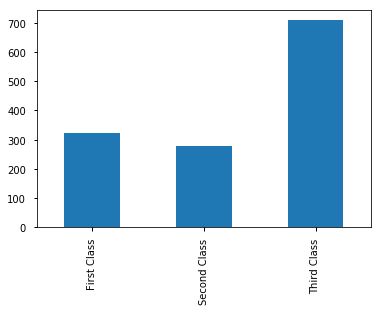

In [23]:
titanic.pclass.value_counts(sort=False).plot(kind='bar')

Next we plot the histogram of the three embark ports.

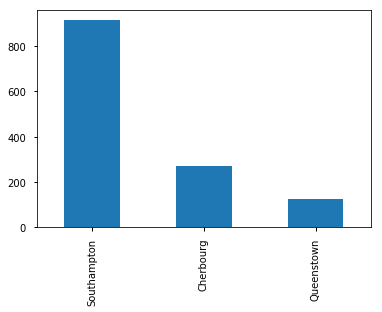

In [24]:
titanic.embarked.value_counts().plot(kind='bar')

Next we plot the histogram of the sex.

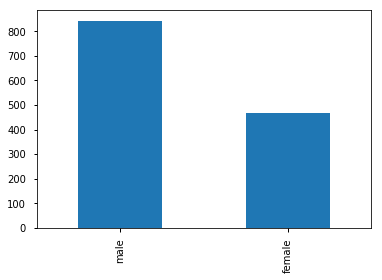

In [25]:
titanic.sex.value_counts().plot(kind='bar')

Next, we cut the ages data into decades and plot the histogram of the devades.

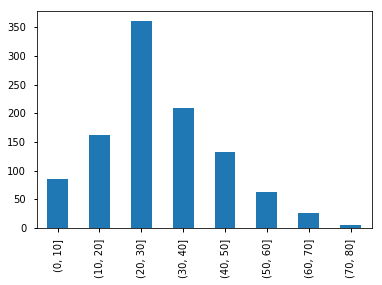

In [26]:
pd.cut(titanic.age, range(0,90,10)).value_counts(sort=False).plot(kind='bar')

**3.** We plot the cabin floor data as a pie chart.

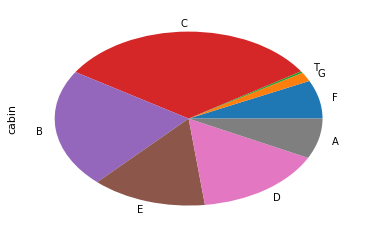

In [27]:
titanic.cabin.dropna().apply(lambda x : x[0]).value_counts(sort=False).plot(kind='pie')

**4.** Here, we plot the proportion of people that survived in the first class.

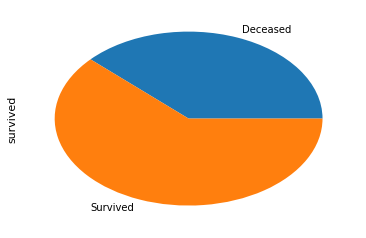

In [28]:
titanic[titanic.pclass == "First Class"].survived.value_counts(sort=False).plot(kind='pie')

Next, we plot the proportion of people that survived in the second class.

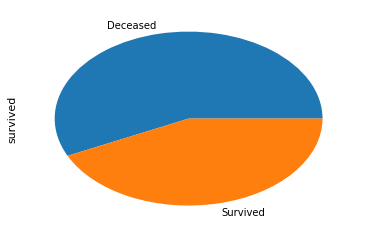

In [29]:
titanic[titanic.pclass == "Second Class"].survived.value_counts(sort=False).plot(kind='pie')

Finally, we plot the proportion of people that survived in the third class.

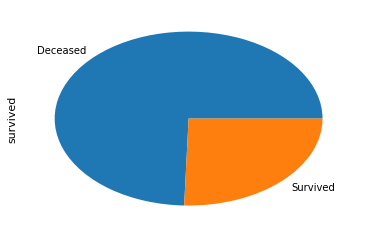

In [30]:
titanic[titanic.pclass == "Third Class"].survived.value_counts(sort=False).plot(kind='pie')

**5.** Here we add new columns that will help us to calculate proportions of survived people in the last part.

In [31]:
titanic.insert(0, 'alive', 0)
titanic.insert(0, 'dead', 0)
titanic.insert(0, 'ratio', 0)

Here we set these new columns to appropriate values. We essentialy separate the survived columns for easier summing later on. Finnaly we slice the data to take only the columns of interest.

In [32]:
titanic.loc[titanic['survived'] == "Survived", 'alive'] = 1
titanic.loc[titanic['survived'] == "Deceased", 'dead'] = 1
df = titanic[['pclass', 'sex', 'alive', 'dead', 'ratio']]

We group the data by the sec and class of the passangers and we sum it. Then we have the sum of alive and dead people groupped as we wish and we can easily calculate the proportion of them that survived, which we plot as a histogram.

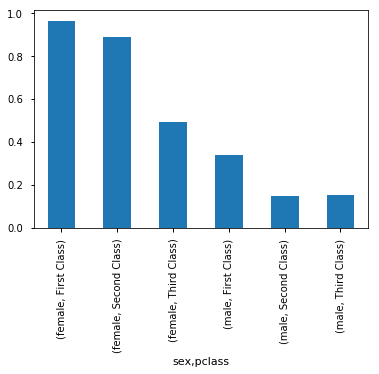

In [33]:
aggregated = df.groupby(['sex', 'pclass']).sum()
(aggregated['alive'] / (aggregated['alive'] + aggregated['dead'])).plot(kind='bar')

**6.** Next we insert a new column that will be the age category of each person. Since we wan't to split the people in two equal groups based on age, we compute the median age of passangers. We also drop the passengers with an unknown age value, to avoid bad results for the median computation. 

In [34]:
titanic.dropna(axis=0, subset=['age'], inplace=True)
titanic.insert(0, 'age_category', 0)
median = titanic['age'].median()

Next, we set the correct category to people below or above the median age. The people that have the median age are grouped with the people below it. Next we set this column as a categorical column.

In [35]:
titanic.loc[titanic['age'] > median, 'age_category'] = "Age > " + str(median)
titanic.loc[titanic['age'] <= median, 'age_category'] = "Age <= " + str(median)
titanic['age_category'] = titanic.age_category.astype('category')

Next, we take the columns that are of interest to us and group by age category, sec and travel class. Then we sum over these groups, obtaining the people that lived and those that died which which we can compute the proportion and display it as a dataframe.

In [36]:
sub = titanic[['pclass', 'sex', 'age_category', 'alive', 'dead', 'ratio']]
subagg = sub.groupby(['age_category', 'sex', 'pclass']).sum()
subagg['ratio'] = (subagg['alive'] / (subagg['alive'] + subagg['dead']))
only_ratio = subagg[['ratio']]
only_ratio

ratio
age_category sex    pclass                
Age <= 28.0  female First Class   0.951220
                    Second Class  0.910714
                    Third Class   0.513761
             male   First Class   0.531250
                    Second Class  0.216216
                    Third Class   0.183036
Age > 28.0   female First Class   0.967391
                    Second Class  0.872340
                    Third Class   0.372093
             male   First Class   0.302521
                    Second Class  0.083333
                    Third Class   0.144000